In [261]:
import numpy as np
from numba import njit

from scipy.stats import binned_statistic_2d
import mpol.constants as const
from mpol import coordinates
from mpol.gridding import DirtyImager
from scipy.spatial import cKDTree
from tqdm import tqdm

plt.style.use("science")

In [10]:
def grid(pixel_scale, img_size): 
    """Given a pixel scale and a number of pixels in image space, grid the associated Fourier space

    Args:
        pixel_scale (float): Pixel resolution (in arcsec)
        img_size (float/int): Size of the image 

    Returns:
    """

    # Arcsec to radians: 
    dl = pixel_scale * const.arcsec
    dm = pixel_scale * const.arcsec

    du = 1 / (img_size * dl) * 1e-3 # klambda
    dv = 1 / (img_size * dm) * 1e-3 # klambda

    u_min = -img_size//2 * du 
    u_max = img_size//2 * du 

    v_min = -img_size//2 * dv
    v_max = img_size//2 * dv

    u_edges = np.linspace(u_min, u_max, img_size + 1)
    v_edges = np.linspace(v_min, v_max, img_size + 1)

    return u_edges, v_edges

In [11]:
# Just take the first spectral window: 
path = "../../Interferometric-imaging-posteriors/data/"
data = np.load(path+"/HTLup_continuum_full.npz")

u = data["uu"]
v = data["vv"]
vis = data["data"]
weight = data["weight"]
vis_per_spw = data["vis_per_spw"]
freq_per_spw = data["freq_per_spw"]
chans_per_spw = np.array([8, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 8])

n_spw = len(vis_per_spw)
print(n_spw)
spw = 14 # pick spectral window

16


In [12]:
idx_freq = np.cumsum(chans_per_spw)
if spw == 0: 
    idx_freq_inf = 0
else: 
    idx_freq_inf = idx_freq[spw-1] 
idx_freq_sup = idx_freq[spw]
freqs_spw = freq_per_spw[idx_freq_inf:idx_freq_sup]
freq = np.mean(freqs_spw)

idx_inf = vis_per_spw[:spw-1].sum()
idx_sup = vis_per_spw[:spw].sum()
u = u[idx_inf:idx_sup]
v = v[idx_inf:idx_sup]
vis = vis[idx_inf:idx_sup]
weight = weight[idx_inf:idx_sup]

# Noé don't forget your minus signs
uu = np.concatenate([u, -u])
vv = np.concatenate([v, -v])

vis_re = np.concatenate([vis.real, vis.real])
vis_imag = np.concatenate([vis.imag, -vis.imag])
weight_ = np.concatenate([weight, weight])

# Reference gridded visibilities

In [316]:
pixel_scale = 0.0015 # real space
pad = 256 #768//2
img_size = 256
npix = img_size + 2 * pad
u_edges, v_edges = grid(pixel_scale = pixel_scale, img_size = npix)
pixel_size = u_edges[1] - u_edges[0] # pixel size in uv space

In [317]:
# Misha's hack setup for binned statistics
# uv = np.stack([u, v], axis=1)
y_re = list(zip(vis_re, weight_, uu, vv))
y_imag = list(zip(vis_imag, weight_, uu, vv))
data_real = np.empty(len(y_re), dtype = object)
data_real[:] = y_re
data_imag = np.empty(len(y_imag), dtype = object)
data_imag[:] = y_imag

u_center = (u_edges[:-1] + u_edges[1:])/2
v_center = (v_edges[:-1] + v_edges[1:])/2
pixel_size = u_edges[1] - u_edges[0]
u_grid, v_grid = np.meshgrid(u_center, v_center, indexing="xy")

u_grid = u_grid.ravel()
v_grid = v_grid.ravel()
# Flatten the u_grid and v_grid and stack them to create 2D array
uv_grid = np.vstack((u_grid.ravel(), v_grid.ravel())).T


In [318]:
def process_binstat(data, weight):
    y = list(zip(data, weight))
    out = np.empty(len(data), dtype = object)
    out[:] = y
    return out

data_real = process_binstat(vis_re, weight_)
data_imag = process_binstat(vis_imag, weight_)

def binned_mean(y):
    y = np.stack(y)
    values = y[:, 0]
    w = y[:, 1]
    return np.average(values, weights = w)

def binned_std(y):
    y = np.stack(y)
    values = y[:, 0]
    w = y[:, 1]
    return np.sqrt(np.cov(values, aweights=w)) #have to use cov since std doesn't accept weights :(

vis_bin_re, _, _, _ = binned_statistic_2d(vv, uu, values = data_real, bins = (v_edges, u_edges), statistic = binned_mean)
std_bin_re, _, _, _ = binned_statistic_2d(vv, uu, values = data_real, bins = (v_edges, u_edges), statistic = binned_std)
counts, _, _, _ = binned_statistic_2d(vv, uu, values = weight_, bins = (v_edges, u_edges), statistic = "count")

/tmp/ipykernel_9302/1350282825.py:20: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.sqrt(np.cov(values, aweights=w)) #have to use cov since std doesn't accept weights :(
/home/alexandre/anaconda3/envs/caustic/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/alexandre/anaconda3/envs/caustic/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [319]:
# From object type to float
vis_bin_re = vis_bin_re.astype(float)
std_bin_re = std_bin_re.astype(float) 
counts = counts.astype(float)

# i.e. The sampling function where there is data in the uv plane
mask = counts>0 

# binned_stat outputs nans, we put everything to zero instead
vis_bin_re[~mask] = 0.
std_bin_re[~mask] = 0.

std_bin_re /= (counts + 1)**0.5

# For the inference, fftshift + flatten everything for the fft
vis_gridded_re = np.fft.fftshift(vis_bin_re).flatten()
std_gridded_re = np.fft.fftshift(std_bin_re).flatten()
S_grid = np.fft.fftshift(mask).flatten()


# Pillbox window

See http://www.gmrt.ncra.tifr.res.in/doc/WEBLF/LFRA/node90.html for a reference

An important properties of the windows we will consider is that they factorize over the coordinates. 
$$
C(u, v) = C(u) C(v)
$$


First, let's consider the simplest convolutional window, which is constant within m pixels. We generally choose $m=1$, i.e. a single pixel for the pillbox window. 

The Pillbox convolutional window is
$$
    C(u) = \left\{ \begin{matrix}1, & |u - \bar{u}| \leq m \Delta u/2 \\ 0, & \text{otherwise} \end{matrix} \right.
$$
where $\bar{u}$ is the center of a pixel in our $(u,v)$-grid and $\Delta u$ is the size of a pixel in the $(u,v)$-grid. 

We can test our algorithm with this window and $m=1$. With these parameters, our algorithm should be exactly equivalent to binned statistics. 

Notice that this naive window is rather bad for inference, as it introduce import sidelobes in the reconstruction. Using this window function is equivalent to the multiplication of our signal with $c(x) = \mathcal{F}^{-1}C(u)$, the Fourier transform of the window function.

$$
\begin{align}
    c(x) &= \frac{1}{m \Delta u} \int_{-m \Delta u / 2}^{m \Delta u /2} e^{i2 \pi  ux } du \\
        &= \frac{1}{m \Delta u (i 2 \pi x)} \Big[e^{i2\pi u x} \Big]_{u = - m \Delta u / 2}^{m \Delta u /2} 
\end{align}
$$
Using Euler's formula, we find
$$
    c(x) = \frac{1}{\pi m \Delta u x} \sin( \pi m \Delta u x)
$$
Using the definition $\text{sinc}(x) = \frac{\sin(\pi x)}{\pi x}$, we can write this more compactly as
$$
    c(x) = \text{sinc}(m \Delta u x)
$$

This sinc function is the reason we get important sidelobes during the reconstructions. What we could do is multiply our solution by $c(x)$ in order to account for this effect. What we will do instead is more clever. We will use the sinc function as our window function, s.t. $c(x)$ becomes a pillbox function in real space!

In [320]:
def pillbox_window(u, center, pixel_size=pixel_size, m=1):
    """
    u: coordinate of the data points to be aggregated (u or v)
    center: coordinate of the center of the pixel considered. 
    pixel_size: Size of a pixel in the (u,v)-plane
    m: size of the truncation of this window (in term of pixel_size)
    """
    return np.where(np.abs(u - center) <= m * pixel_size / 2, 1, 0)

In [321]:
from typing import Callable
# for speed test remove prints
def bin_data(u, v, values, weights, bins, window_fn, truncation_radius, statistics_fn="mean", verbose=0):
    u_edges = bins[0]
    v_edges = bins[1]
    
    grid = np.zeros((len(u_edges)-1, len(v_edges)-1))
    if verbose:
        print("Fitting the KD Tree on the data...")
    # Build a cKDTree from the data points coordinates to query uv points in our truncation radius
    uv_grid = np.vstack((u.ravel(), v.ravel())).T
    tree = cKDTree(uv_grid)
    
    if verbose:
        print("Gridding...")
    for i in tqdm(range(len(u_edges)-1), disable=not verbose):
        for j in range(len(v_edges)-1):
            # Calculate the coordinates of the center of the current cell in our grid
            u_center = (u_edges[i] + u_edges[i+1])/2 
            v_center = (v_edges[j] + v_edges[j+1])/2
            
            # Query the tree to find the points within the truncation radius of the cell
            indices = tree.query_ball_point([u_center, v_center], truncation_radius, p=1) # p=1 is the Manhattan distance (L1)
            
            # Apply the convolutional window and weighted averaging
            if len(indices) > 0:
                value = values[indices]
                weight = weights[indices] * window_fn(u[indices], u_center) * window_fn(v[indices], v_center)
                if weight.sum() > 0.: # avoid dividing by a normalization = 0
                    if statistics_fn=="mean":
                        grid[j, i] = (value * weight).sum() / weight.sum()
                    elif statistics_fn=="std":
                        # See https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
                        grid[j, i] = np.sqrt(np.cov(value, aweights=weight))
                    elif statistics_fn=="count":
                        grid[j, i] = (weight > 0).sum()
                    elif isinstance(statistics_fn, Callable):
                        grid[j, i] = statistics_fn(value, weight)
                        
    return grid

## Compute gridded visibilities and compare with reference

In [322]:
m = 1
truncation_radius = m * pixel_size

args = (uu, vv, vis_re, weight_, (u_edges, v_edges), pillbox_window, truncation_radius)
our_vis_bin_re = bin_data(*args, statistics_fn="mean", verbose=1)
our_std_bin_re = bin_data(*args, statistics_fn="std", verbose=1)
our_count = bin_data(*args, statistics_fn="count", verbose=1)

our_re_std = our_std_bin_re / (our_count + 1)**(1/2)

Fitting the KD Tree on the data...
Gridding...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:13<00:00, 56.37it/s]


Fitting the KD Tree on the data...
Gridding...


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 364/768 [00:04<00:08, 50.38it/s]/tmp/ipykernel_9302/1799539844.py:34: RuntimeWarning: Degrees of freedom <= 0 for slice
  grid[j, i] = np.sqrt(np.cov(value, aweights=weight))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:26<00:00, 28.61it/s]


Fitting the KD Tree on the data...
Gridding...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:12<00:00, 60.48it/s]


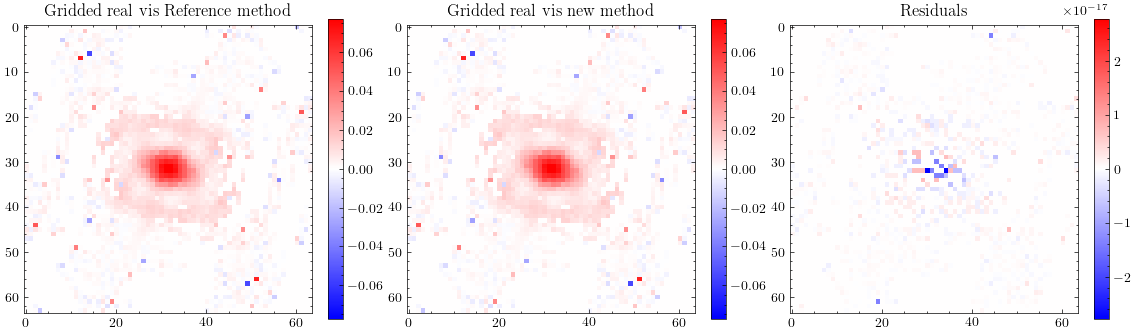

In [323]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

p = npix//2
m = 32
im = ax1.imshow(vis_bin_re[p-m:p+m, p-m:p+m], cmap="bwr", norm=plt.cm.colors.CenteredNorm())
ax1.set_title(r"Gridded real vis Reference method")
plt.colorbar(im, ax=ax1, fraction=0.047)

ax2.set_title(r"Gridded real vis new method")
im = ax2.imshow(our_vis_bin_re[p-m:p+m, p-m:p+m], cmap="bwr", norm=plt.cm.colors.CenteredNorm())
plt.colorbar(im, ax=ax2, fraction=0.047)


im = ax3.imshow(vis_bin_re[p-m:p+m, p-m:p+m] - our_vis_bin_re[p-m:p+m, p-m:p+m], cmap="bwr", norm=plt.cm.colors.CenteredNorm())
ax3.set_title("Residuals")
plt.colorbar(im, ax=ax3, fraction=0.047)

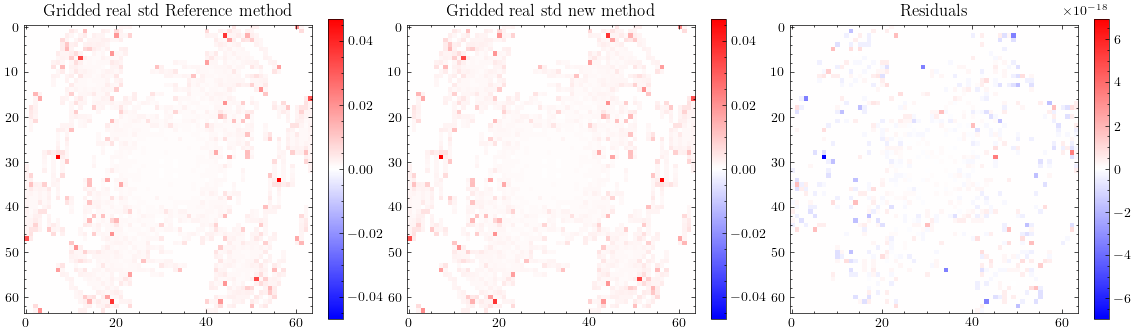

In [324]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

p = npix//2
m = 32
im = ax1.imshow(std_bin_re[p-m:p+m, p-m:p+m], cmap="bwr", norm=plt.cm.colors.CenteredNorm())
ax1.set_title(r"Gridded real std Reference method")
plt.colorbar(im, ax=ax1, fraction=0.047)

ax2.set_title(r"Gridded real std new method")
im = ax2.imshow(our_re_std[p-m:p+m, p-m:p+m], cmap="bwr", norm=plt.cm.colors.CenteredNorm())
plt.colorbar(im, ax=ax2, fraction=0.047)


im = ax3.imshow(std_bin_re[p-m:p+m, p-m:p+m] - our_re_std[p-m:p+m, p-m:p+m], cmap="bwr", norm=plt.cm.colors.CenteredNorm())
ax3.set_title("Residuals")
plt.colorbar(im, ax=ax3, fraction=0.047)

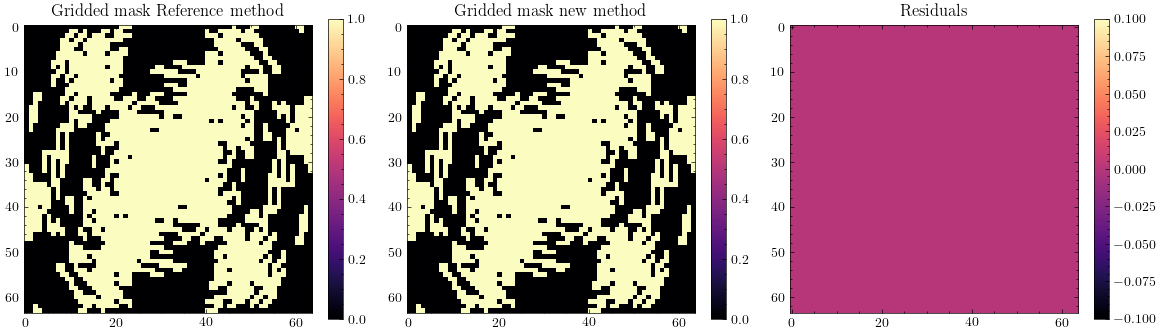

In [325]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

mask = (counts > 0).astype(float)
our_mask = (our_count > 0).astype(float)

p = npix//2
m = 32
im = ax1.imshow(mask[p-m:p+m, p-m:p+m]>0, cmap="magma")
ax1.set_title(r"Gridded mask Reference method")
plt.colorbar(im, ax=ax1, fraction=0.047)

ax2.set_title(r"Gridded mask new method")
im = ax2.imshow(our_mask[p-m:p+m, p-m:p+m], cmap="magma")
plt.colorbar(im, ax=ax2, fraction=0.047)


im = ax3.imshow(mask[p-m:p+m, p-m:p+m] - our_mask[p-m:p+m, p-m:p+m], cmap="magma")
ax3.set_title("Residuals")
plt.colorbar(im, ax=ax3, fraction=0.047)

In [326]:
# %%timeit
# vis_bin_re, _, _, _ = binned_statistic_2d(vv, uu, values = data_real, bins = (v_edges, u_edges), statistic = binned_mean)

In [174]:
%%timeit
our_vis_bin_re = bin_data(
    u=uu, 
    v=vv, 
    values=vis_re, 
    weights=weight_, 
    bins=(u_edges, v_edges), 
    window_fn=pillbox_window, # 1 inside a pixel, 0 outside
    truncation_radius=pixel_size,
    statistics_fn="mean"
)


9.82 s ± 71.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Now that we calibrated our algorithm, let's try more fancy window functions!

In [211]:
def sinc_window(u, center, pixel_size=pixel_size, m=1):
    """
    u: coordinate of the data points to be aggregated (u or v)
    center: coordinate of the center of the pixel considered. 
    pixel_size: Size of a pixel in the (u,v)-plane
    m: size of the truncation of this window (in term of pixel_size)
    """
    return np.sinc(np.abs(u - center) / m / pixel_size * 2)

In [212]:
pixel_scale = 0.0015 # real space
pad = 0#256 #768//2
img_size = 256
npix = img_size + 2 * pad
u_edges, v_edges = grid(pixel_scale = pixel_scale, img_size = npix)
pixel_size = u_edges[1] - u_edges[0] # pixel size in uv space

In [220]:
m = 1 # allow window to spill over
truncation_radius = m * pixel_size
window_fn = pillbox_window # overwrite m with our truncation window
args = (uu, vv, vis_re, weight_, (u_edges, v_edges), window_fn, truncation_radius)
vis_bin_re = bin_data(*args, statistics_fn="mean")
args = (uu, vv, vis_imag, weight_, (u_edges, v_edges), window_fn, truncation_radius)
vis_bin_imag = bin_data(*args, statistics_fn="mean")

vis_bin_re_s = []
vis_bin_imag_s = []
for m in [1, 3, 7]:
    truncation_radius = m * pixel_size
    window_fn = lambda u, center: sinc_window(u, center, m=m) # overwrite m with our truncation window
    args = (uu, vv, vis_re, weight_, (u_edges, v_edges), window_fn, truncation_radius)
    vis_bin_re_s.append(bin_data(*args, statistics_fn="mean"))
    args = (uu, vv, vis_imag, weight_, (u_edges, v_edges), window_fn, truncation_radius)
    vis_bin_imag_s.append(bin_data(*args, statistics_fn="mean"))

In [221]:
# To compute the dirty image
vis_grid = np.fft.fftshift(vis_bin_re + 1j * vis_bin_imag)
vis_grid_s = []
for i in range(len(vis_bin_re_s)):
    vis_grid_s.append(np.fft.fftshift(vis_bin_re_s[i] + 1j * vis_bin_imag_s[i]))


def plot_dirty_image(vis_gridded, ax): 
    dirty_image = npix ** 2 * np.fft.fftshift(np.fft.ifft2(vis_gridded))[::-1].real
    im = ax.imshow(dirty_image, origin = "lower", cmap = "magma")  # flip needed due to CASA's convention  
    plt.colorbar(im, ax=ax, fraction = 0.046, label = "Jy/beam ?")

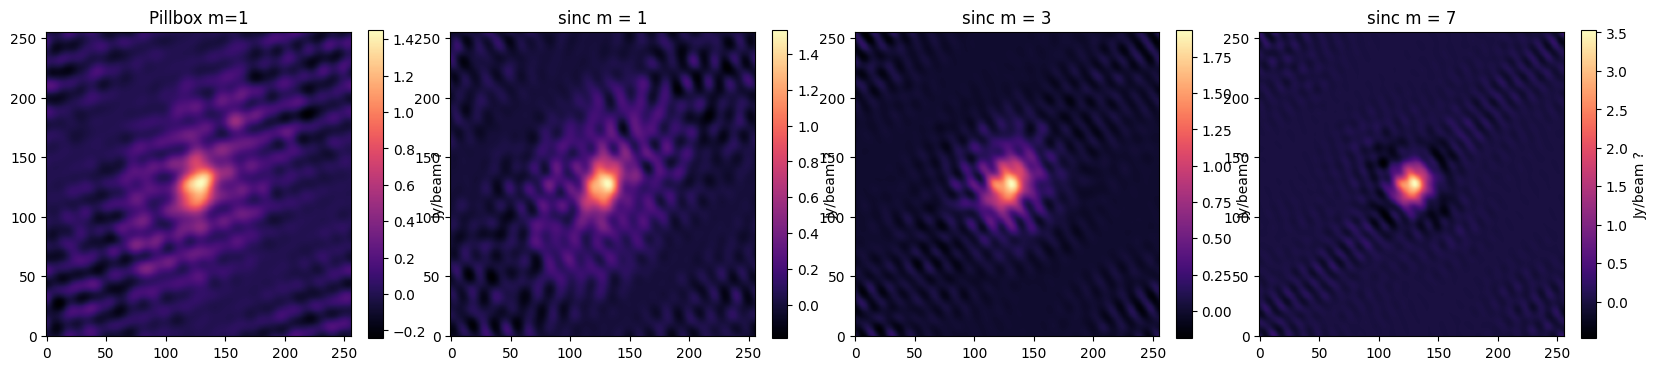

In [230]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))


plot_dirty_image(vis_grid, axs[0])
axs[0].set_title("Pillbox m=1")
for i, ax in enumerate(axs[1:]):
    plot_dirty_image(vis_grid_s[i], ax)
    ax.set_title(fr"sinc m = %d" % [1, 3, 7][i])

# Convolved likelihood and forward model corrections

When using a specific convolution window, we need to take it into account in our forward model. More specifically, we need to take the Fourier transform of our window function and multiply our solution by it when forward modeling. 

We alread did this exercise above for the Pillbox window function. Now we need to write correctly the sinc function in real space.


First, not that $u$ and $\Delta u$ are in $k\lambda$ units. We have access to the frequency of the channel we are studying, thus $\lambda = \frac{c}{f}$, where $c$ is the speed of light and $f$ is in Hz units. 

In order to compute $\text{sinc}(m\Delta u x)$, we have to convert the units of $x$, which are arcseconds, into $(k \lambda)^{-1}$. We can do this with the following trick

$$
    \frac{x}{3600} \times \frac{\pi}{180} \times \frac{f}{c} \times 10^{3}
$$


In [235]:
from astropy.constants import c
from astropy import units

lam = (c / (freq * units.Hz)).decompose()
lam # important that this be in meters

<Quantity 0.00121429 m>

In [239]:
factor = 1 /3600 * np.pi / 180 * (1 / lam.value) * 1e3

pixel_scale * factor

0.005988856874021764

In [240]:
pixel_size

537.1479329351423

Text(0.5, 0, 'x [arcseconds]')

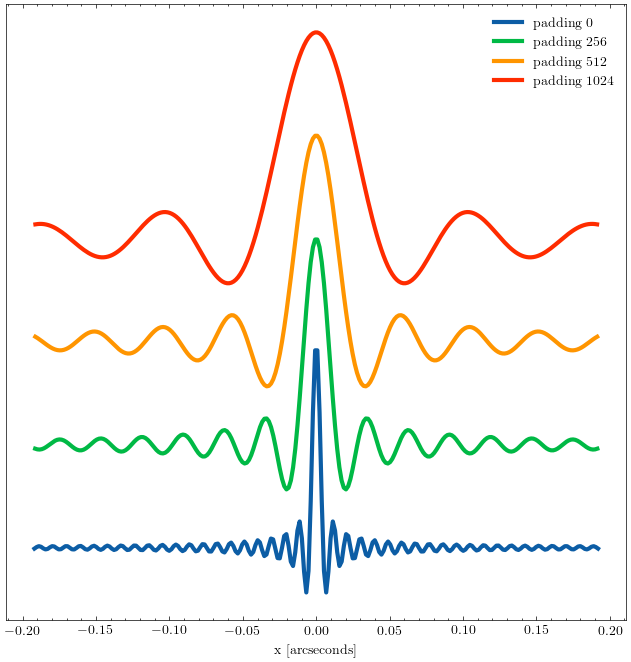

In [330]:
plt.figure(figsize=(8, 8))

for i, pad in enumerate([0, 256, 512, 1024]):
    pixel_scale = 0.0015 # real space
    img_size = 256
    npix = img_size + 2 * pad
    u_edges, v_edges = grid(pixel_scale = pixel_scale, img_size = npix)
    pixel_size = u_edges[1] - u_edges[0] # pixel size in uv space


    fov = pixel_scale * npix
    delta_u = pixel_size
    m = 1

    x = np.linspace(-1, 1, npix) * fov / 2
    real_window = np.sinc(m * x * factor  * delta_u/10)

    n = npix//2
    m = img_size//2
    plt.plot(x[n-m:n+m], real_window[n-m:n+m] + i/2, lw=3, label=f"padding {pad}")
plt.legend()
plt.yticks([])
plt.xlabel(r"x [arcseconds]")